# Sentinel-2 Imagery and Band Compositions

Author: **Marcin Sikorski**<br>
Date: October, 2024

Sentinel-2 carries the Multispectral Imager (MSI). This sensor delivers 13 spectral bands ranging 10, 20, or 60 meter pixel size. There are 13 Sentinel-2 bands in total. By displaying band combinations, we can extract specific information from an raster. For example, there are band combinations that highlight geologic or vegetation features in an image. This notebook will demonstrate the usage of different spectral compositions. The study area will be among river Narew near the towns Wieliszew and Jachranka in Poland.

In [1]:
import rasterio as rio
from pyrsgis import raster
import earthpy.plot as ep
import matplotlib.pyplot as plt

### Read Raster and Metadata

In [2]:
tif_image = 'Sentinel2_Narew.tif'

# read TIF image and get dimensions
with rio.open(tif_image) as src:
    height, width = src.height, src.width
    bands = src.count

print(f'Image shape: (bands: {bands}, height: {height}, width: {width})')

Image shape: (bands: 12, height: 881, width: 1698)


In [3]:
# read TIF image, get metadata, and bands
with rio.open(tif_image) as src:
    # read existing bands
    bands = [src.read(i) for i in range(1, src.count + 1)]
    
    # get band names or descriptions if available
    band_names = [src.descriptions[i] if src.descriptions[i] else f'Band {i + 1}' for i in range(src.count)]

    # get metadata
    metadata = src.meta.copy()
    
print('Metadata:\n', metadata)
print('\nBand names:\n', band_names)

Metadata:
 {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 1698, 'height': 881, 'count': 12, 'crs': CRS.from_epsg(4326), 'transform': Affine(8.983152841195215e-05, 0.0, 20.899484748097493,
       0.0, -8.983152841195215e-05, 52.50131812813814)}

Band names:
 ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']


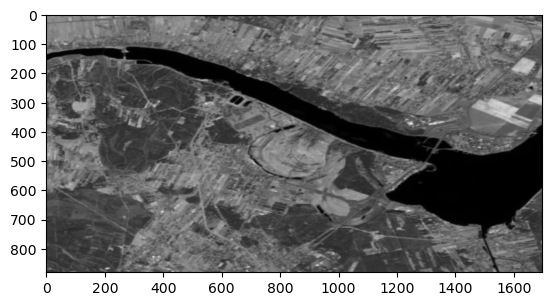

In [4]:
# plot any band
src = rio.open(tif_image)

plt.imshow(src.read(11), cmap='gray')
plt.show()

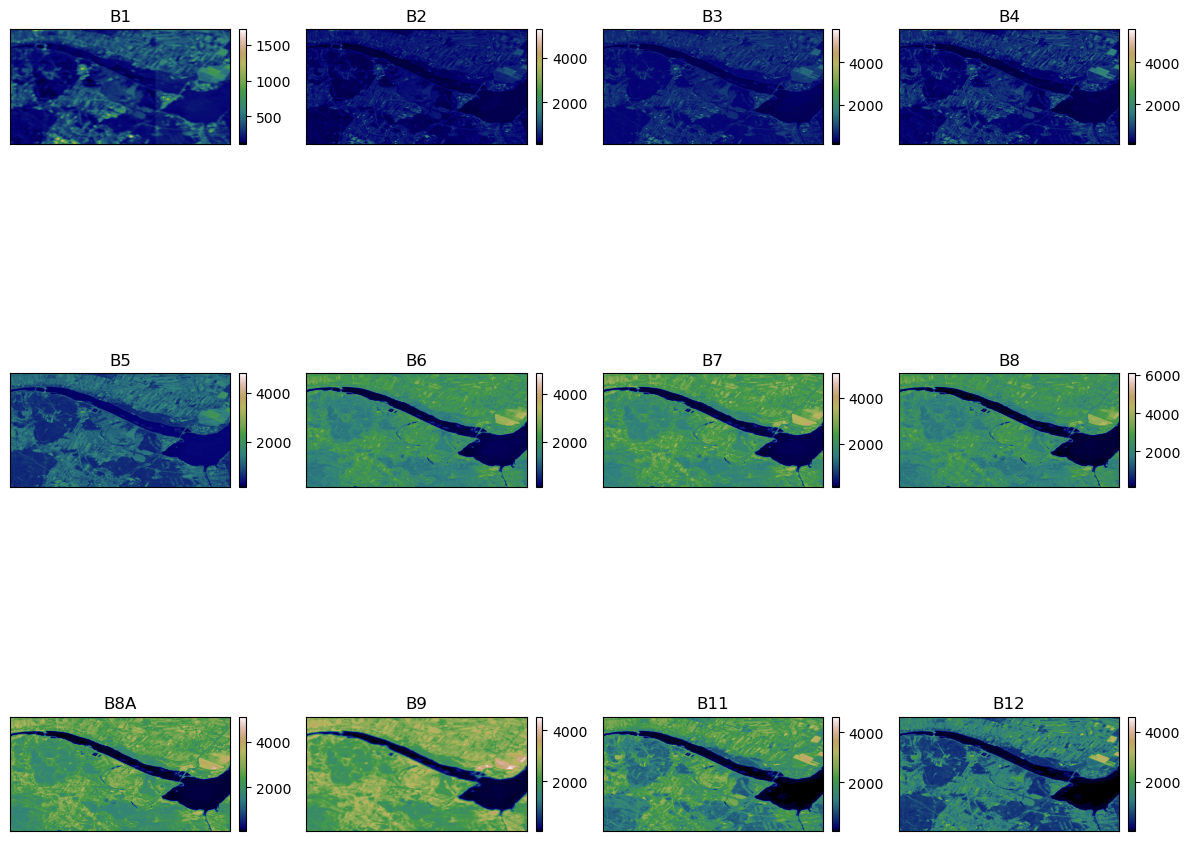

<Figure size 640x480 with 0 Axes>

In [5]:
# plot each band
ds, features = raster.read(tif_image, bands='all')

titles = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']
ep.plot_bands(features, cmap='gist_earth', cols=4, title=titles)

plt.tight_layout()
plt.show()

### Band Compositions

Combining different bands (maximum three) we can understand better the features in imagery. The way we do this is by rearranging the available channels in creative ways. By using band combinations, we can extract specific information from an image. For example, there are band combinations that highlight geologic, agricultural, or vegetation features in an image.

A few examples:
* infrared: highlights chlorophyll on image, denser vegetation is red, urban areas are white;
* snow and clouds: highlights snowy and cloudy areas with white color;
* atmospheric penetration: vegetation appears in blue colors, bare soil in shades of brown and yellow, water is almost black.

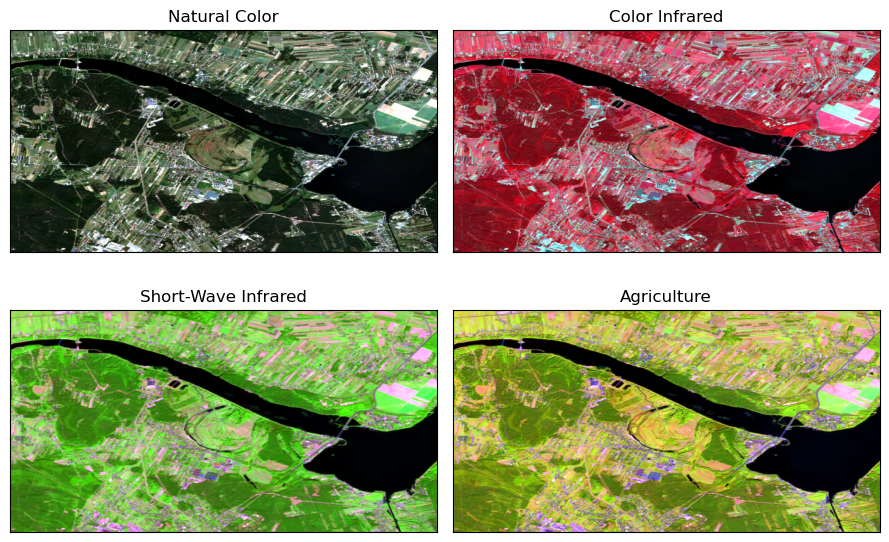

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(9, 6))

# natural color (true color) (B4, B3, B2)
ax1 = axes[0, 0]
ep.plot_rgb(features, rgb=(3, 2, 1), ax=ax1, stretch=True, title='Natural Color')

# color infrared (false color) (B8, B4, B3)
ax2 = axes[0, 1]
ep.plot_rgb(features, rgb=(7, 3, 2), ax=ax2, stretch=True, title='Color Infrared')

# short-wave infrared (SWIR) (B12, B8A, B4)
ax3 = axes[1, 0]
ep.plot_rgb(features, rgb=(11, 8, 3), ax=ax3, stretch=True, title='Short-Wave Infrared')

# agriculture (B11, B8, B2)
ax4 = axes[1, 1]
ep.plot_rgb(features, rgb=(10, 7, 1), ax=ax4, stretch=True, title='Agriculture')

plt.tight_layout()
plt.show()

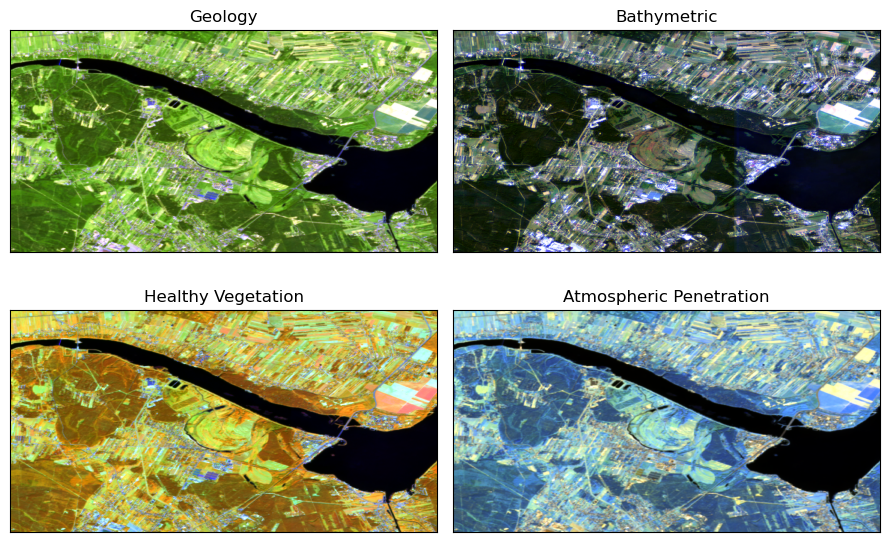

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(9, 6))

# geology (B12, B11, B2)
ax1 = axes[0, 0]
ep.plot_rgb(features, rgb=(11, 10, 1), ax=ax1, stretch=True, title='Geology')

# bathymetric (B4, B3, B1)
ax2 = axes[0, 1]
ep.plot_rgb(features, rgb=(3, 2, 0), ax=ax2, stretch=True, title='Bathymetric')

# healthy vegetation (B8A, B11, B2)
ax3 = axes[1, 0]
ep.plot_rgb(features, rgb=(8, 10, 1), ax=ax3, stretch=True, title='Healthy Vegetation')

# atmospheric penetration (B12, B11, B8A)
ax4 = axes[1, 1]
ep.plot_rgb(features, rgb=(11, 10, 8), ax=ax4, stretch=True, title='Atmospheric Penetration')

plt.tight_layout()
plt.show()

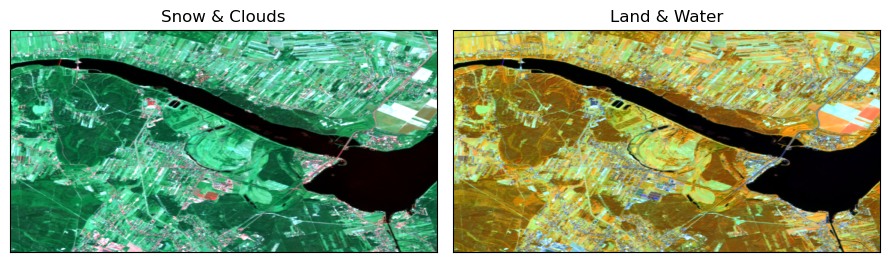

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))

# snow and clouds (B2, B11, B12)
ax1 = ep.plot_rgb(features, rgb=(1, 10, 11), ax=ax1, stretch=True, title='Snow & Clouds')

# land and water (B8, B11, B4)
ax2 = ep.plot_rgb(features, rgb=(7, 10, 3), ax=ax2, stretch=True, title='Land & Water')

plt.tight_layout()
plt.show()

### Add New Bands

With `rasterio`, we can create and customize new bands. We will combine existing channels to create spectral indices. These new indices will then be exported as bands into a new TIF raster. Finally, we will display the results.

In [9]:
import numpy as np

# read original TIF image
with rio.open(tif_image) as src:
    # read the existing bands
    bands = src.read()
    
    # get the metadata
    meta = src.meta.copy()
    
    # define indices as new bands
    veg_index = (bands[7] - bands[3]) / (bands[7] + bands[3])
    mois_index = (bands[8] - bands[10]) / (bands[8] + bands[10])
    mirb_index = 10 * bands[11] - 9.8 * bands[10] + 2
    
    # stack three new bands with the existing
    veg_index = veg_index[np.newaxis, ...]
    mois_index = mois_index[np.newaxis, ...]
    mirb_index = mirb_index[np.newaxis, ...]
    
    new_bands = np.concatenate((bands, veg_index, mois_index, mirb_index), axis=0)

    # update the metadata for the new bands
    meta.update({
        'count': src.count + 3,
        'dtype': 'float32'
    })

# save the new TIF with the added bands
new_image_path = 'new_image.tif'
with rio.open(new_image_path, 'w', **meta) as dst:
    dst.write(new_bands)

'''
# optional: save band names in a metadata TXT file
with open(new_image_path.replace('.tiff', '_band_names.txt'), 'w') as f:
    for name in band_names:
        f.write(f'{name}\n')
'''

print('New bands added successfully')

New bands added successfully


In [10]:
new_tif_image = 'new_image.tif'

# read new TIF image
with rio.open(new_tif_image) as src:
    height, width = src.height, src.width
    bands_ = src.count

    # read existing bands
    bands = [src.read(i) for i in range(1, src.count + 1)]
    
    # get band names or descriptions if available
    band_names = [src.descriptions[i] if src.descriptions[i] else f'Band {i + 1}' for i in range(src.count)]

    
print(f'Image shape: (bands: {bands_}, height: {height}, width: {width})')
print('\nBand names:\n', band_names)

Image shape: (bands: 15, height: 881, width: 1698)

Band names:
 ['Band 1', 'Band 2', 'Band 3', 'Band 4', 'Band 5', 'Band 6', 'Band 7', 'Band 8', 'Band 9', 'Band 10', 'Band 11', 'Band 12', 'Band 13', 'Band 14', 'Band 15']


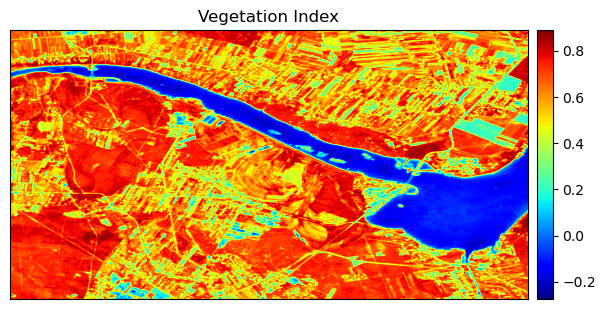

In [11]:
title = 'Vegetation Index'
ep.plot_bands(bands[12], cmap='jet', title=title, figsize=(7, 6))
plt.show()

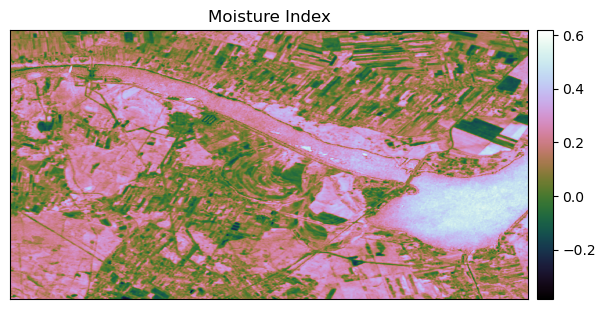

In [12]:
title = 'Moisture Index'
ep.plot_bands(bands[13], cmap='cubehelix', title=title, figsize=(7, 6))
plt.show()

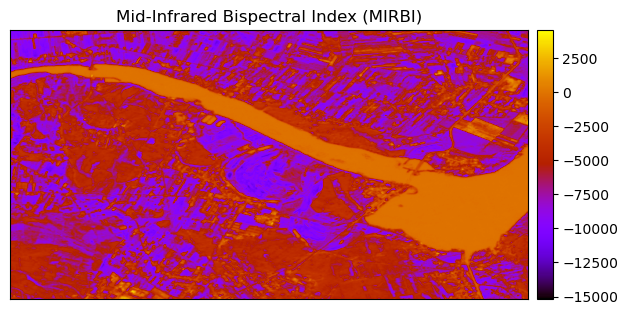

In [13]:
title = 'Mid-Infrared Bispectral Index (MIRBI)'
ep.plot_bands(bands[14], cmap='gnuplot', title=title, figsize=(7, 6))
plt.show()

**References:**
* https://www.gisgeography.com/sentinel-2-bands-combinations/
* https://www.staridasgeography.gr/how-to-make-outstanding-maps-with-sentinel-2-and-arcgis-pro-part-1-band-combinations/